In [2]:
import porepy as pp
import numpy as np
from mat_utils import *
from frac_poromech_small import make_model

model = make_model()
model.prepare_simulation()
pp.run_time_dependent_model(
    model, {"prepare_simulation": False, "progressbars": True}
)

# pp.plot_grid(
#     model.mdg,
#     cell_value=model.pressure_variable,
#     vector_value=model.displacement_variable,
#     alpha=0.5,
# )

model.time_manager.increase_time()
model.time_manager.increase_time_index()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()

model.assemble_linear_system()
mat, rhs = model.linear_system
# spy(mat)
# plt.show()
# plot_mat(mat)
# plt.show()

block_matrix = make_block_mat(model, mat)

/home/porepy/porepy/src/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


time loop:   0%|          | 0/1 [00:00<?, ?it/s]

Newton loop:   0%|          | 0/10 [00:00<?, ?it/s]

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [3]:
sticking, sliding, is_open = model.sticking_sliding_open()
print('sticking:', sum(sticking))
print('sliding:', sum(sliding))
print('open:', sum(is_open))

sticking: 1
sliding: 1
open: 10


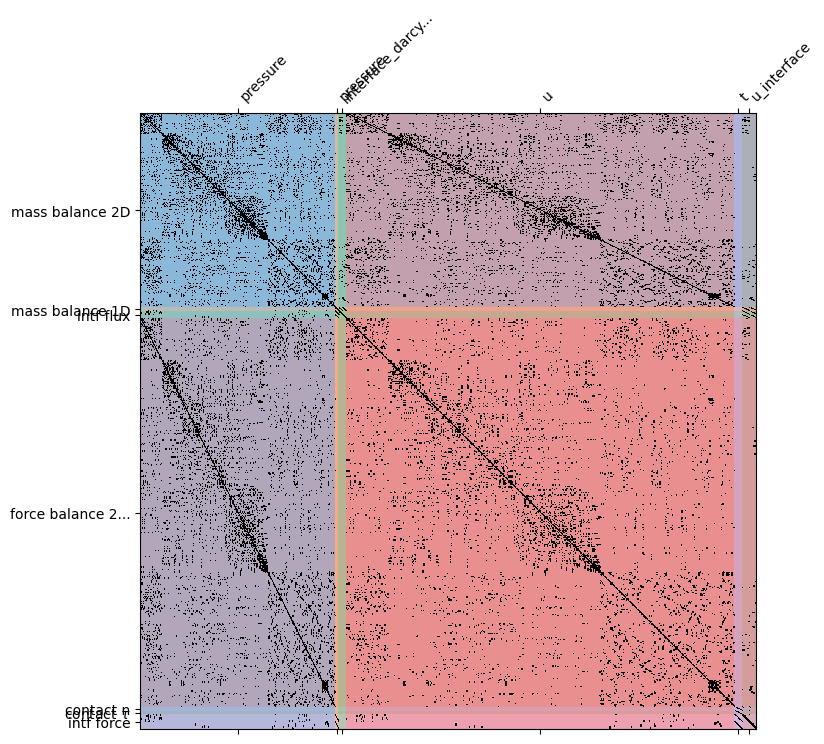

In [4]:
mass_balance_2d = model.mass_balance_equation(model.mdg.subdomains(dim=2))
mass_balance_2d.set_name("mass balance 2D")
mass_balance_1d = model.mass_balance_equation(model.mdg.subdomains(dim=1))
mass_balance_1d.set_name("mass balance 1D")
intf_flow = model.interface_flux_equation(model.mdg.interfaces())
intf_flow.set_name("intf flux")
force_balance = model.momentum_balance_equation(model.mdg.subdomains(dim=2))
force_balance.set_name("force balance 2D")
norm_cont_eq = model.normal_fracture_deformation_equation(model.mdg.subdomains(dim=1))
norm_cont_eq.set_name("contact n")
tang_cont_eq = model.tangential_fracture_deformation_equation(
    model.mdg.subdomains(dim=1)
)
tang_cont_eq.set_name(r"contact $\tau$")
intf_force = model.interface_force_balance_equation(model.mdg.interfaces())
intf_force.set_name("intf force")

# plt.figure(figsize=(8, 8))
# plot_jacobian(
#     model,
#     [
#         mass_balance_1d,
#         intf_flow,
#         norm_cont_eq,
#         tang_cont_eq,
#         intf_force,
#     ],
# )

# plt.figure(figsize=(8, 8))
# plot_jacobian(
#     model,
#     [
#         mass_balance_2d,
#         force_balance,
#     ],
# )

plt.figure(figsize=(8, 8))
plot_jacobian(model, [
    mass_balance_2d,
    mass_balance_1d,
    intf_flow,
    force_balance,
    norm_cont_eq,
    tang_cont_eq,
    intf_force,
])

# Original A, B, C, D (no fractures)

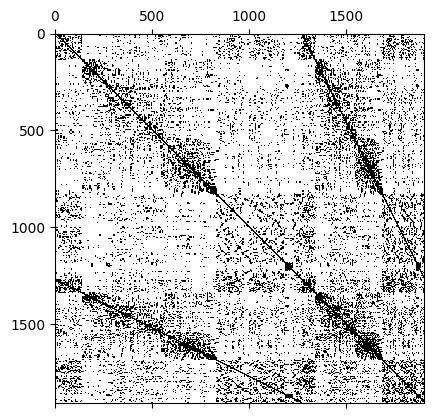

In [5]:
A = block_matrix[0, 0]
B = block_matrix[0, 3]
C = block_matrix[3, 0]
D = block_matrix[3, 3]

Omega = concatenate_blocks(block_matrix, [3, 0], [3, 0])

spy(Omega)
assert (Omega - bmat([[D, C], [B, A]])).data.size == 0

/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/home/porepy/.local/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


error: 8.810729923425242e-12
cond: 8693.581836104793
Solve operator inverse took: 0.01
Solve fixed strain took: 0.02
Solve fixed stress took: 0.02


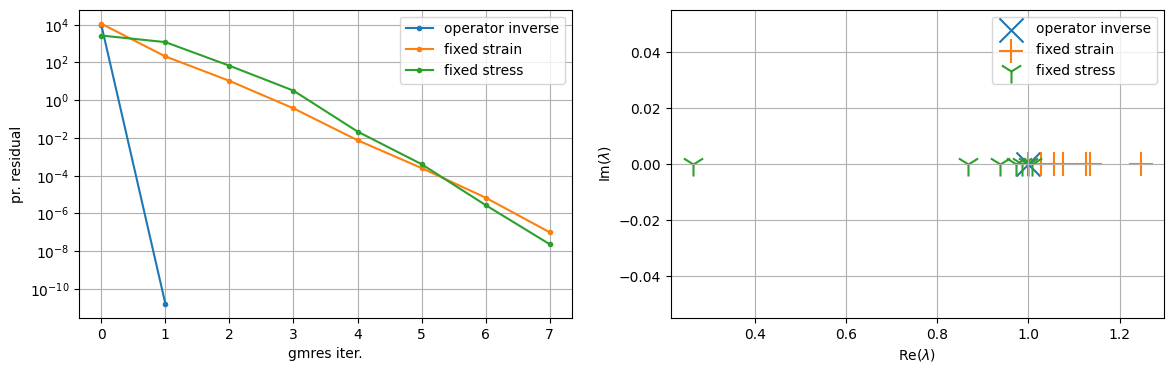

In [6]:
D_inv = inv(D)
S_A = A - B @ D_inv @ C
S_A_inv = inv(S_A)

Omega_inv = inv(Omega)
Omega_inv_op = OmegaInv(solve_momentum=D_inv, solve_mass=S_A_inv, C1=B, C2=C)

Omega_inv_fixed_strain = OmegaInv(solve_momentum=D_inv, solve_mass=inv(A), C1=B, C2=C)

fs = get_fixed_stress_stabilization(model)
S_A_fs = A + fs
Omega_inv_fixed_stress = OmegaInv(solve_momentum=D_inv, solve_mass=inv(S_A_fs), C1=B, C2=C)

ones = np.ones(Omega.shape[0])
expected = Omega_inv.dot(ones)
result = Omega_inv_op.dot(ones)
print("error:", abs(expected - result).max())

print("cond:", cond(Omega))

cb_type = "pr_norm"
# solve_petsc(Omega, label="noprec")
# solve_petsc(Omega, Omega_inv, label="exact inverse")
solve_petsc(Omega, Omega_inv_op, label="operator inverse")
solve_petsc(Omega, Omega_inv_fixed_strain, label="fixed strain")
solve_petsc(Omega, Omega_inv_fixed_stress, label="fixed stress")
plt.legend()
plt.show()

# Modified A, B, C, D (fracture effects)

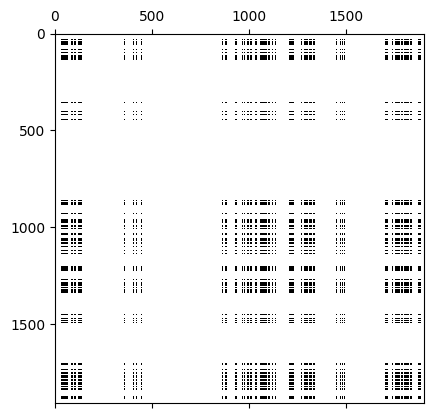

In [7]:
A = block_matrix[0, 0]
B = block_matrix[0, 3]
C = block_matrix[3, 0]
D = block_matrix[3, 3]
E = concatenate_blocks(block_matrix, [0], [1, 2, 4, 5])
F = concatenate_blocks(block_matrix, [3], [1, 2, 4, 5])
G = concatenate_blocks(block_matrix, [1, 2, 4, 5, 6], [0])
H = concatenate_blocks(block_matrix, [1, 2, 4, 5, 6], [3])
K = concatenate_blocks(block_matrix, [1, 2, 4, 5, 6], [1, 2, 4, 5])
Omega = concatenate_blocks(block_matrix, [3, 0], [3, 0])

ones_K = scipy.sparse.eye(K.shape[0])
# K += ones_K

K_inv = inv(K)
E_Km1_G = E @ K_inv @ G
F_Km1_G = F @ K_inv @ G
E_Km1_H = E @ K_inv @ H
F_Km1_H = F @ K_inv @ H

Omega_delta = bmat([
    [- F_Km1_H, - F_Km1_G],
    [- E_Km1_H, - E_Km1_G]
])
spy(Omega_delta)

Solve $\Omega$ took: 0.06
Solve $S_\Omega$ took: 0.04


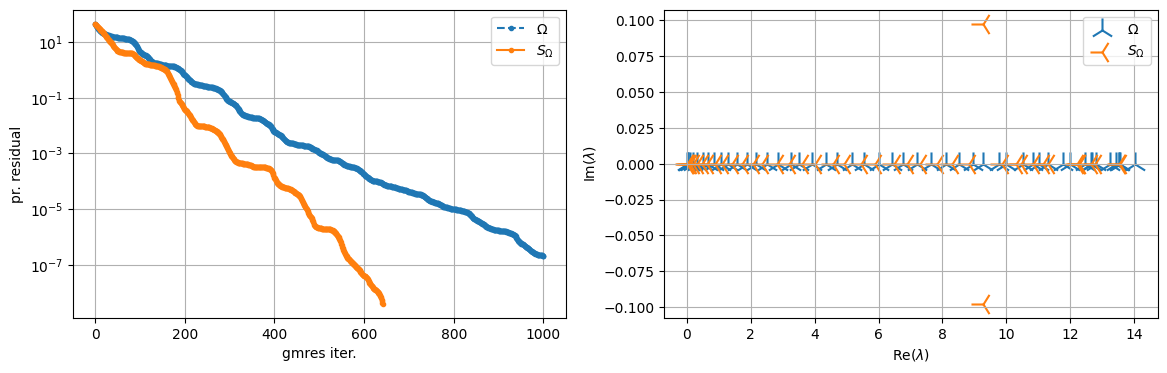

In [8]:
Ap = A - E_Km1_G
Bp = B - E_Km1_H
Cp = C - F_Km1_G
Dp = D - F_Km1_H
Omega_p = bmat(
    [
        [Dp, Cp],
        [Bp, Ap],
    ]
)
assert (Omega_p - (Omega + Omega_delta)).data.size == 0
solve_petsc(Omega, label=r"$\Omega$")
solve_petsc(Omega_p, label=r"$S_\Omega$")
plt.legend()

Solve nofrac took: 0.02
Solve fixed stress took: 0.02


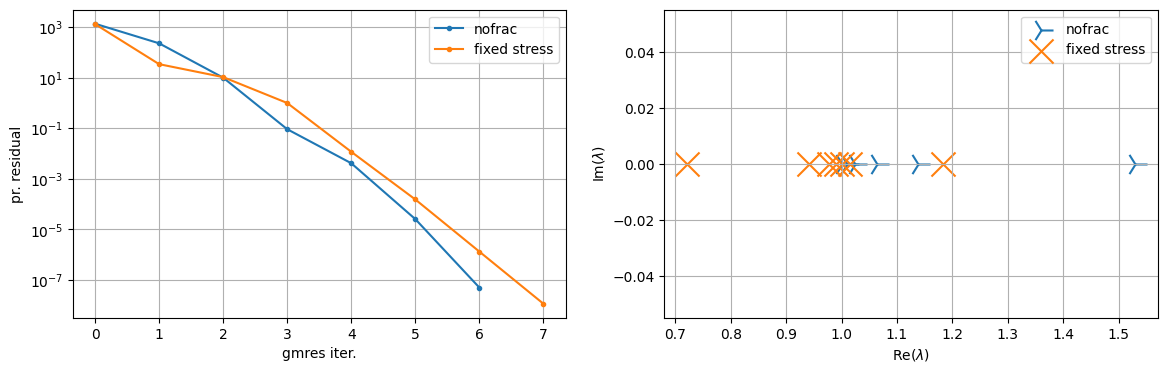

In [9]:
Dp_inv = inv(Dp)
S_Ap = Ap - Bp @ Dp_inv @ Cp
S_Ap_inv = inv(S_Ap)
S_Ap_nofrac = Ap - B @ D_inv @ C
S_Ap_nofrac_inv = inv(S_Ap_nofrac)
S_Ap_fs = Ap + get_fixed_stress_stabilization(model)
S_Ap_fs_inv = inv(S_Ap_fs)

Omega_p_inv = inv(Omega_p)
Omega_p_inv_op = OmegaInv(solve_momentum=Dp_inv, solve_mass=S_Ap_inv, C1=Bp, C2=Cp)
Omega_p_inv_nofrac = OmegaInv(solve_momentum=Dp_inv, solve_mass=S_Ap_nofrac_inv, C1=Bp, C2=Cp)
Omega_p_inv_S_A = OmegaInv(solve_momentum=Dp_inv, solve_mass=S_A_inv, C1=Bp, C2=Cp)
Omega_p_inv_fstress = OmegaInv(solve_momentum=Dp_inv, solve_mass=S_Ap_fs_inv, C1=Bp, C2=Cp)
Omega_p_inv_fstrain = OmegaInv(solve_momentum=Dp_inv, solve_mass=inv(Ap), C1=Bp, C2=Cp)

# solve_petsc(Omega_p, label=r"noprec")
# solve_petsc(Omega_p, Omega_p_inv, label=r"exact prec")
# solve_petsc(Omega_p, Omega_p_inv_op, label=r"exact prec op")
solve_petsc(Omega_p, Omega_p_inv_nofrac, label=r"nofrac")
# solve_petsc(Omega_p, Omega_p_inv_S_A, label=r"$S_A$")
solve_petsc(Omega_p, Omega_p_inv_fstress, label=r"fixed stress")
# solve_petsc(Omega_p, Omega_p_inv_fstrain, label=r"fixed strain")
# plt.legend()

## With AMG

Solve $\Omega$ fixed stress exact took: 0.03
Solve $S_\Omega$ fixed stress exact took: 0.02
Solve $\Omega$ fixed stress amg took: 0.01
Solve $S_\Omega$ fixed stress amg took: 0.02


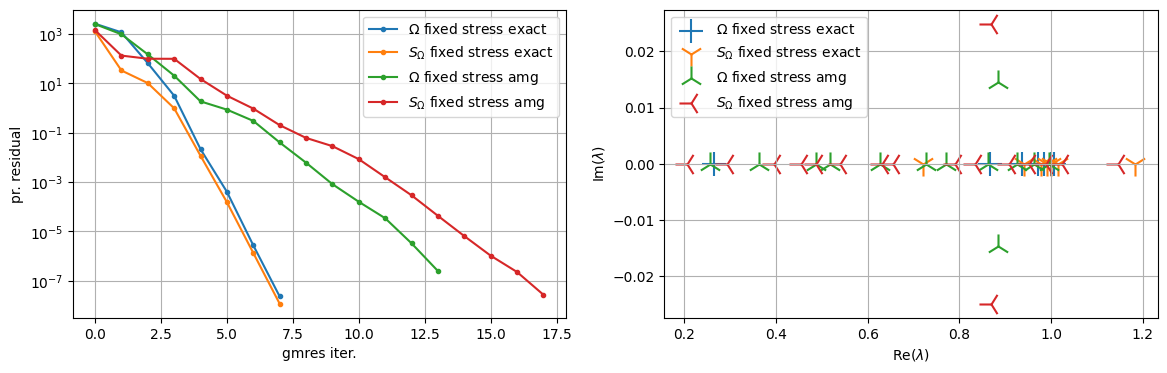

In [10]:
D_amg = PetscAMG(D)
S_A_fs_amg = PetscAMG(S_A_fs)
Omega_amg_fstress = OmegaInv(solve_momentum=D_amg, solve_mass=S_A_fs_amg, C1=B, C2=C)

Dp_amg = PetscAMG(Dp)
S_Ap_fs_amg = PetscAMG(S_Ap_fs)
Omega_p_amg_fstress = OmegaInv(solve_momentum=Dp_amg, solve_mass=S_Ap_fs_amg, C1=Bp, C2=Cp)

solve_petsc(Omega, Omega_inv_fixed_stress, label=r'$\Omega$ fixed stress exact')
solve_petsc(Omega_p, Omega_p_inv_fstress, label=r'$S_\Omega$ fixed stress exact')
solve_petsc(Omega, Omega_amg_fstress, label=r"$\Omega$ fixed stress amg")
solve_petsc(Omega_p, Omega_p_amg_fstress, label=r"$S_\Omega$ fixed stress amg")
plt.legend()

# Full matrix

Solve Exact $\tilde C_2 \cdot \tilde B^{-1} \cdot \tilde C_1$; Exact inverse of $S_{\tilde A}$ took: 0.02
Solve Fixed stress; Exact inverse of $S_{\tilde A}$ and $\tilde B$ took: 0.02
Solve Fixed stress, AMG inverse of $S_{\tilde A}$ and $\tilde B$ took: 0.02
Solve No $\Psi \cdot F^{-1} \cdot \Phi$ term took: 0.18


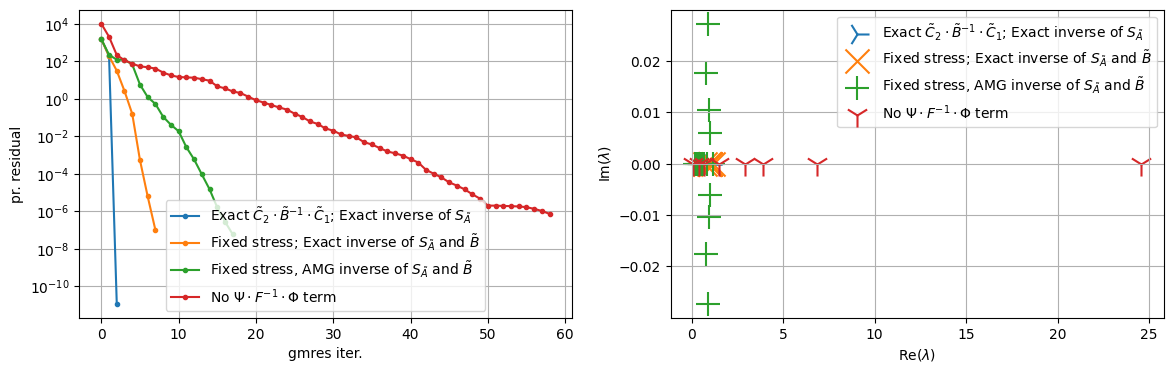

In [11]:
Phi = concatenate_blocks(block_matrix, [1, 2, 4, 5, 6], [3, 0])

full_mat = concatenate_blocks(block_matrix, [1, 2, 4, 5, 6, 3, 0], [1, 2, 4, 5, 3, 0])
prec_exact = UpperBlockPreconditioner(F_inv=K_inv, Omega_inv=Omega_p_inv, Phi=Phi)
prec_fstress = UpperBlockPreconditioner(F_inv=K_inv, Omega_inv=Omega_p_inv_fstress, Phi=Phi)
prec_fstress_amg = UpperBlockPreconditioner(F_inv=K_inv, Omega_inv=Omega_p_amg_fstress, Phi=Phi)
prec_omega = UpperBlockPreconditioner(F_inv=K_inv, Omega_inv=Omega_inv, Phi=Phi)
prec_fstress_omega = UpperBlockPreconditioner(F_inv=K_inv, Omega_inv=Omega_inv_fixed_stress, Phi=Phi)

cb_type = 'pr_norm'
# solve(full_mat, label='noprec')
# plt.figure(figsize=(13, 4))
solve_petsc(full_mat, prec_exact, label=r'Exact $\tilde C_2 \cdot \tilde B^{-1} \cdot \tilde C_1$; Exact inverse of $S_{\tilde A}$')
solve_petsc(full_mat, prec_fstress, label=r'Fixed stress; Exact inverse of $S_{\tilde A}$ and $\tilde B$')
solve_petsc(full_mat, prec_fstress_amg, label=r'Fixed stress, AMG inverse of $S_{\tilde A}$ and $\tilde B$')
solve_petsc(full_mat, prec_omega, label=r'No $\Psi \cdot F^{-1} \cdot \Phi$ term')

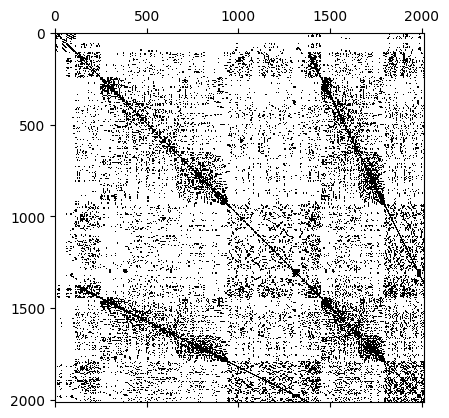

In [12]:
row_dof, col_dof = make_row_col_dofs(model)
permutation = make_permutations(row_dof, order=[1, 2, 4, 5, 6, 3, 0])
spy(permutation @ mat @ permutation.T)

# How do fractures affect AMG performance for ths single-physics blocks?

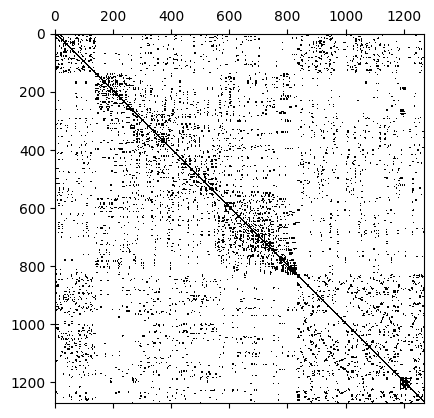

In [13]:
spy(D)

Solve B AMG took: 0.01
Solve $\tilde B$ AMG took: 0.01
Solve B no prec took: 0.0
Solve $\tilde B$ no prec took: 0.01


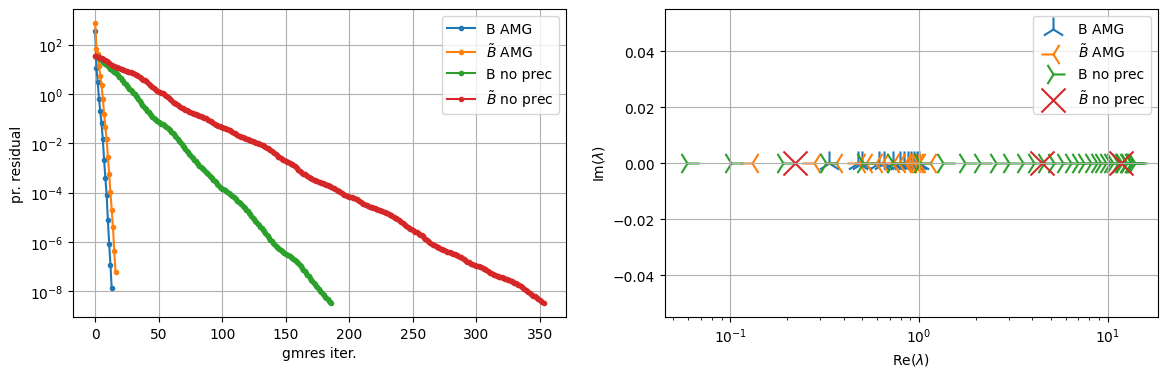

In [14]:
from mat_utils import PetscAMG

D_prec = PetscAMG(D)
Dp_prec = PetscAMG(Dp)

solve_petsc(D, D_prec, label='B AMG')
solve_petsc(Dp, Dp_prec, label=r'$\tilde B$ AMG')

solve_petsc(D, label='B no prec')
solve_petsc(Dp, label=r'$\tilde B$ no prec')
plt.legend()
plt.xscale('log')

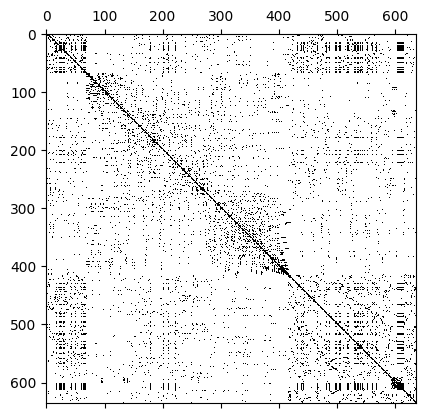

In [15]:
spy(Ap)

Solve A AMG took: 0.0
Solve $\tilde A$ AMG took: 0.0
Solve A no prec took: 0.01
Solve $\tilde A$ no prec took: 0.0


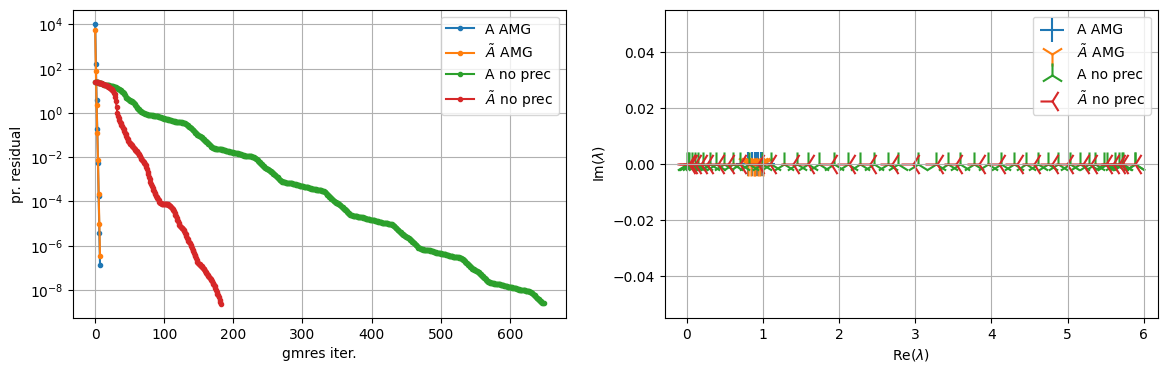

In [16]:
from mat_utils import PetscAMG

A_prec = PetscAMG(A)
Ap_prec = PetscAMG(Ap)

solve_petsc(A, A_prec, label='A AMG')
solve_petsc(Ap, Ap_prec, label=r'$\tilde A$ AMG')

solve_petsc(A, label='A no prec')
solve_petsc(Ap, label=r'$\tilde A$ no prec')

Solve $S_A$ fs AMG took: 0.0
Solve $\tilde S_A$ fs AMG took: 0.0


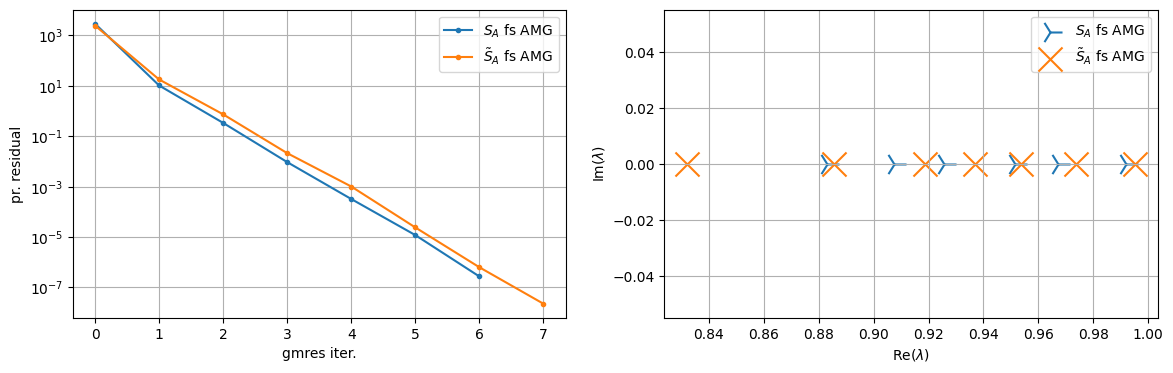

In [17]:
from mat_utils import PetscAMG

S_A_fs_prec = PetscAMG(S_A_fs)
S_Ap_fs_prec = PetscAMG(S_Ap_fs)

solve_petsc(S_A_fs, S_A_fs_prec, label='$S_A$ fs AMG')
solve_petsc(S_Ap_fs, S_Ap_fs_prec, label=r'$\tilde S_A$ fs AMG')

# solve_petsc(S_A_fs, label='$S_A$ fs no prec')
# solve_petsc(S_Ap_fs, label=r'$\tilde S_A$ fs no prec')

# K approximation

Note: K is not degenerate, but poorly conditioned

Text(0.5, 1.0, 'F')

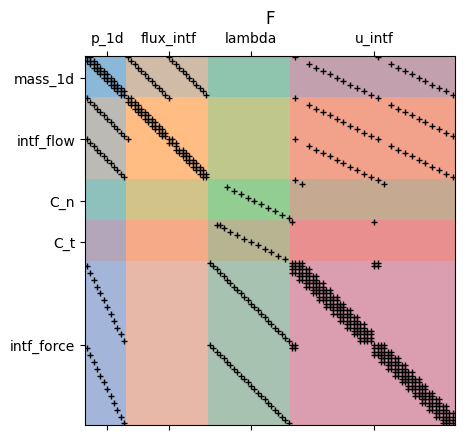

In [18]:
color_spy(block_matrix, [1, 2, 4, 5, 6], [1, 2, 4, 5], ['mass_1d', 'intf_flow', 'C_n', 'C_t', 'intf_force'], ['p_1d', 'flux_intf', 'lambda', 'u_intf'])
plt.title("F")

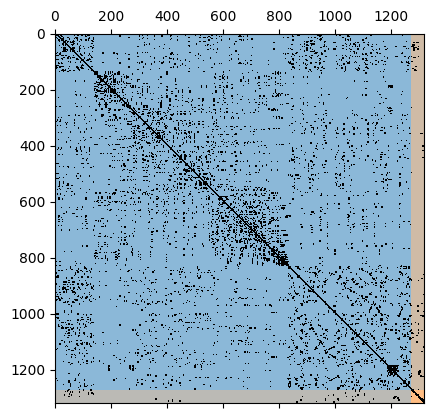

In [19]:
force = concatenate_blocks(block_matrix, [3, 6], [3, 5])
color_spy(block_matrix, [3, 6], [3, 5])
plt.show()
# solve(force, PetscAMG(force), label='both')
# solve(block_matrix[3, 3], PetscAMG(block_matrix[3, 3]), label='force 2d')
# plt.legend()

Solve jacobi took: 0.0


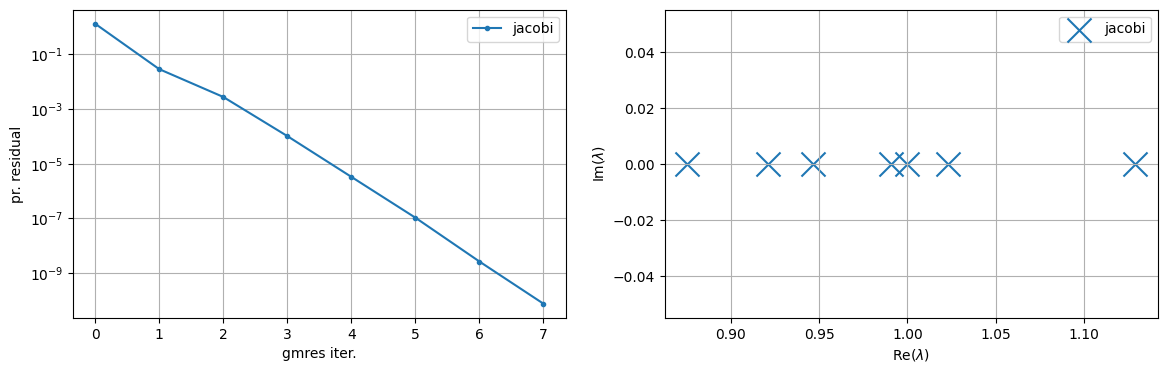

In [31]:
# solve_petsc(block_matrix[6, 5], PetscAMG(block_matrix[6, 5]), label='amg')
# solve_petsc(block_matrix[6, 5], PetscILU(block_matrix[6, 5]), label='ilu')
solve_petsc(block_matrix[6, 5], PetscJacobi(block_matrix[6, 5]), label='jacobi')
# solve_petsc(block_matrix[6, 5], label='no prec')

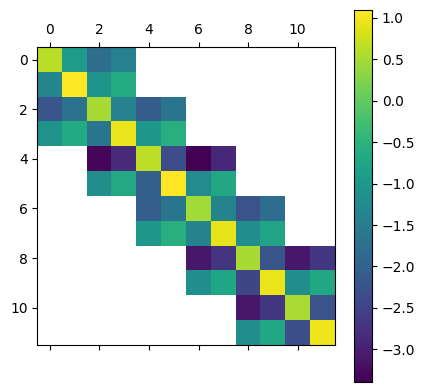

In [28]:
plot_mat(block_matrix[6, 5][:12, :12])

In [22]:
block_matrix[6, 5].shape

(48, 48)